<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
     <img style="float: right; padding-right: 10px" width="100" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>
     </div>

**Clemson University**<br>
**Instructor(s):** Aaron Masino <br>

## Lab 12: Dimensionality Reduction with PCA

In this brief lab, we apply _Principal Components Analysis (PCA)_ to a simulated dataset. We will develop a PCA model using [scikit-learn](https://scikit-learn.org/stable/index.html).

In [85]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans, AgglomerativeClustering as HClust
from sklearn.model_selection import cross_val_score
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import numpy as np
import os

In [86]:
# global settings
pd.options.display.max_columns = 100
rs = 654321 # random state, use this to ensure reproducibility

# Simulated data

To get started, let's generate simulated data for classification. Here, we will craete a dataset with __many more features than samples__. This is representative of many genomics experiments where we may measure expression levels of many or all of the more than 20,000 human genes in a relatively smaller population. We will use this data to illustrate PCA. We will also demonstrate how PCA can be used to transform the data and improve classification model results on the test data.

To generate the simulated data, we use the `make_classification` method from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#). For demonstration, we will split the data into training and test sets.

In [87]:
# generate simulated classification data
n = 200 # number of samples
n_train = 150
n_features = 1000
n_classes = 4
X, y = make_classification(n_samples=n, n_features=n_features, n_informative=5, n_redundant=100,
                           n_classes=n_classes, n_clusters_per_class=1, 
                           flip_y=0.01, class_sep=1.0, hypercube=True, weights=None,
                           shift=0.0, scale=2.0, shuffle=True, random_state=rs)

# split into train and test
X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:]
y_test = y[n_train:]

# PCA

## Simulated Data

Let's start by applying the PCA to the simulated data. We use the scikit-learn [PCA module][https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html]. To obtain the PCA transformation of the data, we apply the `PCA.fit_transform` method to the training data, `X_train`.

In [88]:
# fit the PCA model
sim_pca = PCA()
sim_train_scores = sim_pca.fit_transform(X_train)

Although the data may have up to $min\left(n-1, p\right)$, where here $n=n_{train}=150$ and $p=n_{features}=1000$, we will see that much of the variance is accounted for by a smaller number of principal components and that we can achieve higher classifier performance with a small number of principal components as compared to using all the features.

First, let's plot the data using the first two principal components and then using the first and third principal components. To do so, we use the `sim_train_scores` variable which contains the transformation of the original data, `X_train` to the principal components using a linear combination of the original features where the coeficients are the _loading factors_ for each original feature for the given principal component.

Text(0, 0.5, 'PC3')

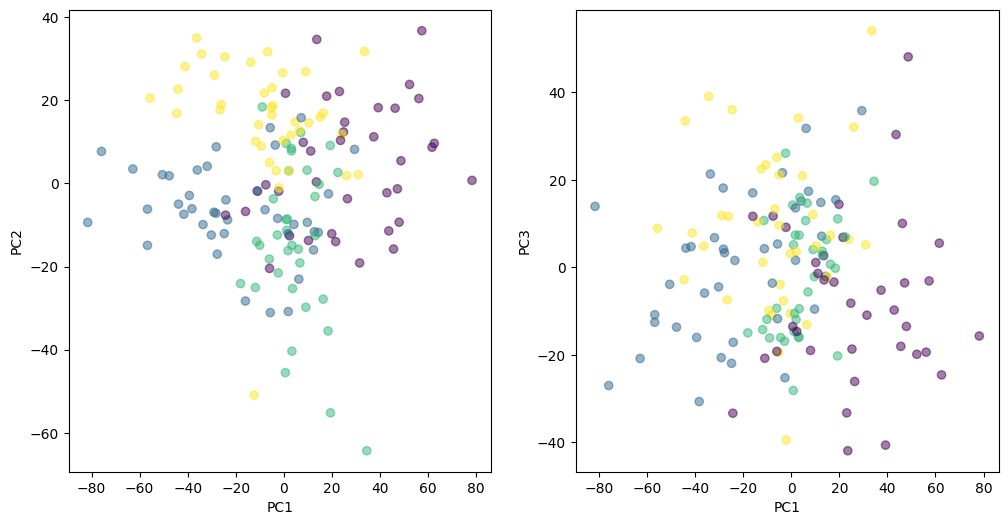

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]
ax.scatter(sim_train_scores[:, 0], sim_train_scores[:, 1], c=y_train, cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')

ax = axes[1]
ax.scatter(sim_train_scores[:, 0], sim_train_scores[:, 2], c=y_train, cmap='viridis', alpha=0.5)
ax.set_xlabel('PC1'); ax.set_ylabel('PC3')

The plot markers are colored by their class membership. Even though this data was created with a 1000 features, we can see that in the principal component space samples in the same class tend to cluster together.

To get a better sense of the propportion of variance explained (PVE), we can plot the PVE as a function of the principal components. This is known as a a __scree plot__. We can also plot the cumulative sum of the PVE as a function of the principal component index. From the _scree plot_, we see that there is an inflection at the $5^{th}$ principal component indicating that subsequent principal components explain much less of the variance than the first 5 principal components. Additionally, the plot of the cumulative PVE indicates that about 50% of the variance is explained by the first 25 principal components, while the remaining components are needed to account for the remaining variance.

Text(0, 0.5, 'Cumulative Proportion Variance Explained (PVE)')

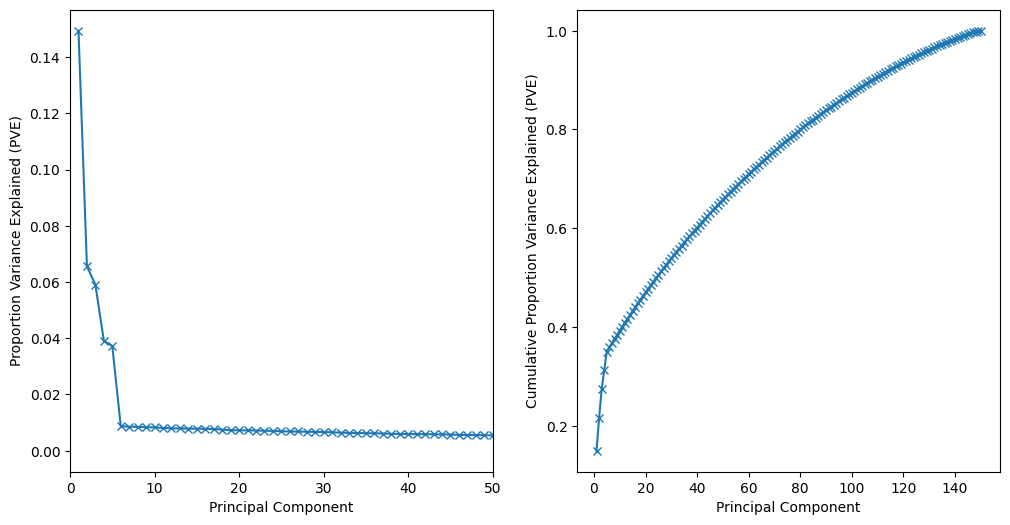

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
ax = axes[0]

ticks = np.arange(sim_pca.n_components_)+1
ax.plot(ticks,
        sim_pca.explained_variance_ratio_,
        marker='x')
ax.set_xlim(0,50)
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion Variance Explained (PVE)')

ax = axes[1]
ax.plot(ticks,
        sim_pca.explained_variance_ratio_.cumsum(),
        marker='x')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion Variance Explained (PVE)')

Finally, we can compare the performance of a logistic regression classifier trained to predict class membership using all of the features (with regularization) vs. one trained on data transformed to scores using only the first 5 principal components. We expect that, on the test set, the model trainined with the principal components score features will perform better. Caution, this is only a single experiment and is not representative of every case.

In [91]:
clf_all = LogisticRegression(random_state=rs).fit(X_train, y_train)
sim_test_scores = sim_pca.transform(X_test)
n_components = 5
sim_test_scores.shape
clf_pca = LogisticRegression(random_state=rs).fit(sim_train_scores[:, :n_components], y_train)

print(classification_report(y_test, clf_all.predict(X_test)))

print(classification_report(y_test, clf_pca.predict(sim_test_scores[:, :n_components])))

              precision    recall  f1-score   support

           0       0.79      0.85      0.81        13
           1       0.50      0.44      0.47         9
           2       0.73      0.73      0.73        15
           3       0.77      0.77      0.77        13

    accuracy                           0.72        50
   macro avg       0.70      0.70      0.70        50
weighted avg       0.71      0.72      0.72        50

              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.64      0.78      0.70         9
           2       0.83      0.67      0.74        15
           3       0.83      0.77      0.80        13

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.77        50
weighted avg       0.79      0.78      0.78        50

